In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import torchvision.models as models  # torchvision.models import 추가
import torchvision.transforms as transforms  # 전처리를 위한 추가

# Google Drive 연결
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# SignClassifier 클래스 정의
class SignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SignClassifier, self).__init__()
        # MobileNetV3 모델을 가져와 수정
        self.model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
        # Adaptive Average Pooling 추가하여 고정된 크기의 출력 얻기
        self.model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 기존의 classifier를 제거하고 새로운 다층 구조 추가
        self.model.classifier = nn.Sequential(
            nn.Linear(576, 128),  # Adaptive Pooling 후 크기 576을 사용
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout 추가
            nn.Linear(128, 64),  # 두 번째 레이어
            nn.ReLU(),
            nn.Linear(64, num_classes)  # 마지막 레이어
        )

    def forward(self, x):
        x = self.model.features(x)  # 특징 추출 부분
        x = self.model.avgpool(x)   # Adaptive Pooling으로 크기 고정
        x = torch.flatten(x, 1)  # (batch_size, 576)으로 평탄화
        x = self.model.classifier(x)  # 새로운 classifier 통과
        return x

In [3]:

# 모델 경로 설정 (Google Drive)
model_path = '/content/drive/MyDrive/2024 덕성여대 졸업 프로젝트/model.pth'

# 모델 로드 함수
def load_model(model_path):
    model = SignClassifier(num_classes=4)  # 클래스 수에 맞게 모델 정의
    model.load_state_dict(torch.load(model_path))  # 학습된 가중치 로드
    model.eval()
    return model

# 모델 로드
model = load_model(model_path)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 68.5MB/s]
<ipython-input-3-c729015a75a2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full c

In [4]:
# GPU 사용 여부 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
# 이미지 로드 함수
def load_single_image(image_path):
    if os.path.isfile(image_path) and (image_path.endswith(".jpg") or image_path.endswith(".png")):
        image = Image.open(image_path).convert('RGB')
        image_name = os.path.basename(image_path)
        return [image], [image_name]  # 리스트 형태로 반환
    else:
        print("이미지 파일을 찾을 수 없습니다.")
        return [], []

# 이미지 경로 설정 (단일 이미지 파일 경로 설정)
image_path = '/content/drive/MyDrive/2024 덕성여대 졸업 프로젝트/CNN 데이터셋/TrafficSign.png'
images, image_names = load_single_image(image_path)

# 이미지 로드 확인
print(f"Loaded {len(images)} image: {image_names}")


Loaded 1 image: ['TrafficSign.png']


---- Original Predictions ----
Image TrafficSign.png: notEnter

---- After FGSM Attack Predictions ----
Image TrafficSign.png: notEnter


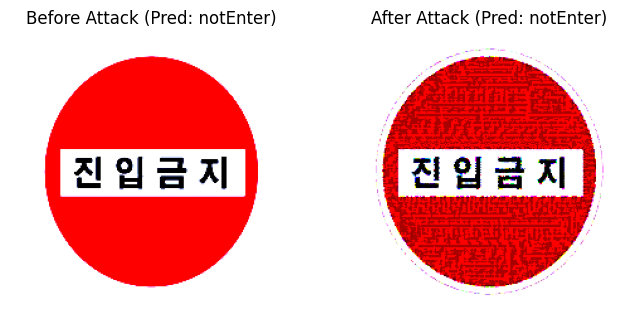

In [20]:
# FGSM 공격 함수 정의 (정규화 해제된 노이즈 추가)
def fgsm_attack(model, images, labels, eps):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    # 모델의 예측과 손실 계산
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    # 손실에 대한 기울기 계산
    model.zero_grad()
    loss.backward()

    # FGSM 방식으로 노이즈 추가
    noise = eps * images.grad.sign()
    perturbed_images = images + noise
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  # 이미지 범위 제한
    return perturbed_images

# 공격 전후 예측 결과 비교
eps = 0.8  # 노이즈 강도
adv_images = fgsm_attack(model, processed_images, labels, eps)

print("---- Original Predictions ----")
with torch.no_grad():
    for i, img in enumerate(processed_images):
        pred = model(img.unsqueeze(0)).argmax(dim=1).item()
        print(f"Image {image_names[i]}: {classes[pred]}")

print("\n---- After FGSM Attack Predictions ----")
with torch.no_grad():
    for i, adv_img in enumerate(adv_images):
        pred = model(adv_img.unsqueeze(0)).argmax(dim=1).item()
        print(f"Image {image_names[i]}: {classes[pred]}")

# 원본 이미지와 공격 후 이미지 비교 시각화
def imshow(img, title):
    img = img.detach().cpu().permute(1, 2, 0)  # 연산 추적을 제거하고 채널 순서 변경
    img = torch.clamp(img, 0, 1)  # 값 범위 제한
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')


# 시각화
for i in range(min(10, len(processed_images))):
    plt.figure(figsize=(8, 4))

    # 원본 이미지 시각화
    plt.subplot(1, 2, 1)
    imshow(processed_images[i], f"Before Attack (Pred: {classes[model(processed_images[i].unsqueeze(0)).argmax(dim=1).item()]})")

    # 공격 후 이미지 시각화
    plt.subplot(1, 2, 2)
    imshow(adv_images[i], f"After Attack (Pred: {classes[model(adv_images[i].unsqueeze(0)).argmax(dim=1).item()]})")

    plt.show()
